In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# Vanishing/Exploding Gradients problem
# - gradients often smaller and smaller as the algorithm progresses down to the lower layers
# - lower layer connection weights almost unchanged and the training does not converge well

# - Sometimes opposite can happen - gradients grow bigger and bigger - large weight updates and algorithm diverges
# - mostly encountered in RNNs

# In general, deep neural networks suffer from ustable gradeints, i.e. different layers may learn at widely different speeds
# Potential causes (paper in 2010, https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf):
# - popular logistic sigmoid activation function
# - weight initialization technique - random with normal distribution with 0 meand and 1 std. dev.
# --> with this setup variance of outputs of each layer >>> variance of its inputs
#     by going forward in the network, the variance keeps increasing after each layer
#     until the activation function saturates at the top layer
# (made even worse since logistic function has a mean of 0.5 and not 0, hyperbolic tangent f. behaves better)

In [5]:
# Logistic activation function:
def logit(z):
    return 1 / (1 + np.exp(-z))

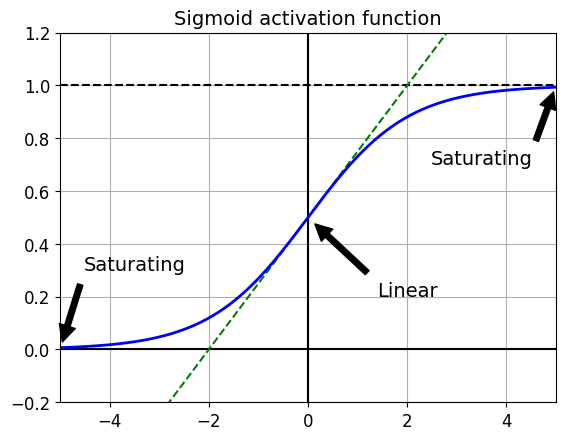

In [6]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [8]:
# Glorot and He initialization
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'IdentityInitializer',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'OrthogonalInitializer',
 'RandomNormal',
 'RandomUniform',
 'STFT',
 'STFTInitializer',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'stft',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [9]:
# How to solve?
# Objective: signal needs to flow properly in both directions:
# don't want the signal to die out, nor to explode and saturate

# Authors of the above paper argue that to achieve this behaviour, variance of the input needs to be
# equal to the variance of the output of each layer, also need this in the reverse direction
# Actually not possible to guarantee both unless the layer has the same number of input and neurons (fan-in and fan-out)
# Authors propose a good compromise which works well in practice:
# - connection weights of each layer must be initialized randomly as described on page 328
# - fan_avg = (fan_in + fan_out)/2
# - for ligistic activation function: Normal dist. - mean 0 and var sigma^2 = 1/fan_avg
#       or uniform distribution between -r and r with r=sqrt(3/fan_avg)
# Called Glorot or Xavier initialization
# Replacing fan_avg wiht fan_in --> strategy already proposed by LeCun in 1990s
# - can speed up training considerably

# He initialization - for ReLU & variants only changes the scale of variance - 2/fan_in (sigma^2)

In [10]:
# By default Keras uses Glorot initialization with uniform distribution
# can be changed with kernel_initializer parameter

keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

<Dense name=dense, built=False>

In [12]:
# based on fan_avg instead of fan_in:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

<Dense name=dense_1, built=False>

In [13]:
# Nonsaturating Activation Function
# Alternatives to "poor" activation functions (biological neurons use sigmoid shaped ones)
# Others, e.g. RELU, better since it does not saturate for positive values (and is fast to compute)

# ReLU - no perfect - dying ReLus problem: during training some neurons "die" (only ouput 0), esp. with large learning rate
# Happens when its weights get tweaked such that sum of all inputs < 0 --> Output always = 0

# Leaky RelU can solve this problem:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

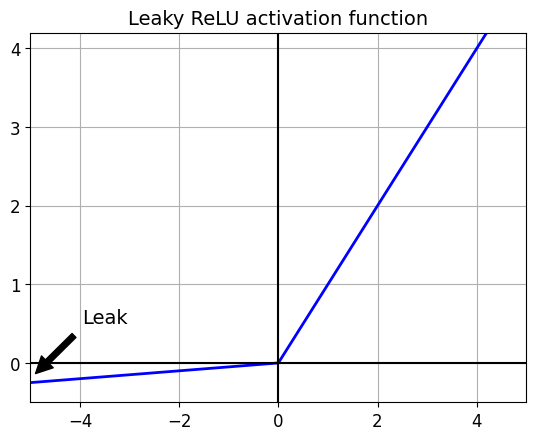

In [14]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [15]:
# This small slope ensures the neurons never die, can go into coma but have a chance to wake up
# 2015 paper compared several variants of ReLU and concluded that leaky variants always outperformed strict ReLU
# setting alpa = 0.2 (huge leak) resulted better than alpa = 0.01
# random alpha in a range during traing seemed to act as a regularized (reduce risk of overfittin)

# Another option: alpha also learned during training instead of being a hyperparameter - can be modified by backpropagation
# - strongly outperform ReLU on large image datasets but risks overfitting on smaller training sets

In [16]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['celu',
 'deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'glu',
 'hard_shrink',
 'hard_sigmoid',
 'hard_silu',
 'hard_swish',
 'hard_tanh',
 'leaky_relu',
 'linear',
 'log_sigmoid',
 'log_softmax',
 'mish',
 'relu',
 'relu6',
 'selu',
 'serialize',
 'sigmoid',
 'silu',
 'soft_shrink',
 'softmax',
 'softplus',
 'softsign',
 'squareplus',
 'swish',
 'tanh',
 'tanh_shrink']

In [17]:
# In 2015 Clevert proposed a function exponential linear unit (ELU) - outperformed all ReLU variants
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

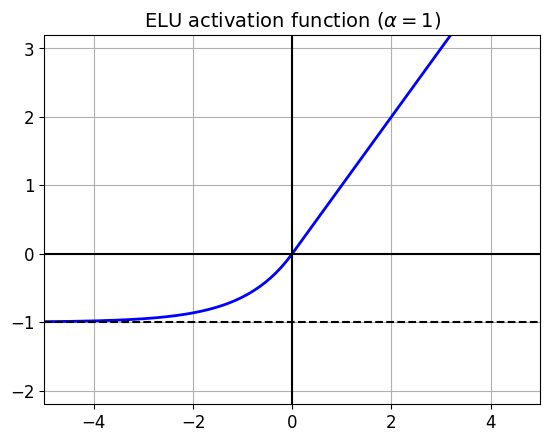

In [18]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [19]:
# Similar to ReLU with a few differences
# 1. takes on negative values when z<0 - allows unit to have an av.g output closet to 0
#   - helps with the vanishing gradient problem
# - hyperparam alpha defines the value ELU approaches when z is large negative number (normally set to 1)
# 2. nonzero gradient for z<0 - avoids dead neurons problem
# 3. when alpah = -1 the function is smooth everywhere including z=0 - helps speed up gradient Descent since it does not bounce around z=0

# Main drawback - slower to compute than ReLu 9 variants (being exp. function) but it has faster convergence rate
# At test time ELU network slower than ReLU network

In [20]:
# For stack of dense layers with SELU (scaled ELU) the network self-normalizes
# - each layer preserve mean 0 and std. dev. 1 - solves vanishing/exploding gradients problem
# - thus this function outperforms others significantly for deep NNs but this happens only under certain conditions:
# 1. Input features standardized
# 2. Each hidden layer weights - LeCun normal init.
# 3. Network must be sequential
# 4. Guarantees self-normalization if all layers are dense.
# In practice it works well with CNNS as well

In [22]:
# Activation function grades, in general:
# SELU > ELU > leakyReLU > ReLU> tanh > logistic

# If network prevents from sel-norm. then ELU might be better than SELU
# Cross valiadation can be used to evaluate different activation functions, e.g. RReLU if overfitting
# or PReLU if dataset is huge

In [23]:
# Test of different functions
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [24]:
# ReLU
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [26]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4703 - loss: 1.6654 - val_accuracy: 0.6976 - val_loss: 0.9017
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7108 - loss: 0.8606 - val_accuracy: 0.7638 - val_loss: 0.7196
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7652 - loss: 0.7100 - val_accuracy: 0.7928 - val_loss: 0.6403
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7899 - loss: 0.6378 - val_accuracy: 0.8056 - val_loss: 0.5928
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8037 - loss: 0.5930 - val_accuracy: 0.8172 - val_loss: 0.5604
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8129 - loss: 0.5619 - val_accuracy: 0.8234 - val_loss: 0.5368
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8194 - loss: 0.5389 - val_accuracy: 0.8258 - val_loss: 0.5188
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8231 - loss: 0.5212 - 

In [27]:
# PReLU
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [29]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4471 - loss: 1.7439 - val_accuracy: 0.7196 - val_loss: 0.9254
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7323 - loss: 0.8714 - val_accuracy: 0.7748 - val_loss: 0.7302
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7709 - loss: 0.7160 - val_accuracy: 0.7980 - val_loss: 0.6466
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7921 - loss: 0.6418 - val_accuracy: 0.8116 - val_loss: 0.5961
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8047 - loss: 0.5957 - val_accuracy: 0.8206 - val_loss: 0.5618
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8128 - loss: 0.5639 - val_accuracy: 0.8274 - val_loss: 0.5365
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8186 - loss: 0.5402 - val_accuracy: 0.8340 - val_loss: 0.5169
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8240 - loss: 0.5215 - 

In [30]:
# ELU
keras.layers.Dense(10, activation="elu")

<Dense name=dense_8, built=False>

In [31]:
# SELU 
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [32]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

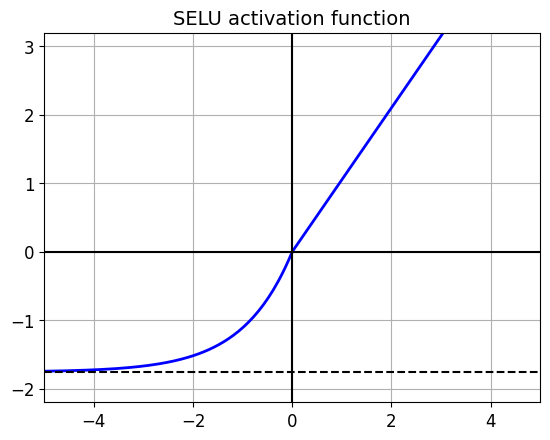

In [33]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [34]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [35]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

<Dense name=dense_9, built=False>

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [40]:
# Normalize inputs
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [41]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.3234 - loss: 1.6928 - val_accuracy: 0.5272 - val_loss: 1.1749
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5935 - loss: 1.0117 - val_accuracy: 0.6838 - val_loss: 0.8102
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.7058 - loss: 0.7809 - val_accuracy: 0.7236 - val_loss: 0.7278
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7560 - loss: 0.6652 - val_accuracy: 0.7798 - val_loss: 0.6019
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.7716 - loss: 0.6189 - val_accuracy: 0.7888 - val_loss: 0.5792


In [42]:
# Lets compare ReLU

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [45]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.1543 - loss: 2.1429 - val_accuracy: 0.2308 - val_loss: 1.6865
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.3579 - loss: 1.5311 - val_accuracy: 0.4570 - val_loss: 1.2641
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5226 - loss: 1.1443 - val_accuracy: 0.6680 - val_loss: 0.9351
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.6252 - loss: 0.9489 - val_accuracy: 0.6702 - val_loss: 0.8521
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.7027 - loss: 0.8046 - val_accuracy: 0.6956 - val_loss: 0.7891
